# Longitudinal LiNGAM

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot

import warnings
warnings.filterwarnings('ignore')

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.24.4', '2.0.3', '0.20.3', '1.9.1']


## Test data
We create test data consisting of 5 variables. The causal model at each timepoint is as follows.

In [2]:
# setting
n_features = 5
n_samples = 200
n_lags = 2
n_timepoints = 4

causal_orders = []
B_t_true = np.empty((n_timepoints, n_features, n_features))
B_tau_true = np.empty((n_timepoints, n_lags, n_features, n_features))
X_t = np.empty((n_timepoints, n_samples, n_features))

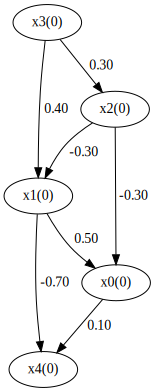

In [3]:
# B(0,0)
B_t_true[0] = np.array([[0.0, 0.5,-0.3, 0.0, 0.0],
                        [0.0, 0.0,-0.3, 0.4, 0.0],
                        [0.0, 0.0, 0.0, 0.3, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.1,-0.7, 0.0, 0.0, 0.0]])
causal_orders.append([3, 2, 1, 0, 4])
make_dot(B_t_true[0], labels=[f'x{i}(0)' for i in range(5)])

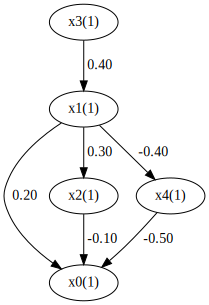

In [4]:
# B(1,1)
B_t_true[1] = np.array([[0.0, 0.2,-0.1, 0.0,-0.5],
                        [0.0, 0.0, 0.0, 0.4, 0.0],
                        [0.0, 0.3, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0,-0.4, 0.0, 0.0, 0.0]])
causal_orders.append([3, 1, 2, 4, 0])
make_dot(B_t_true[1], labels=[f'x{i}(1)' for i in range(5)])

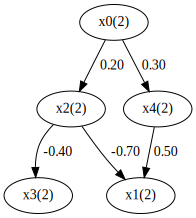

In [5]:
# B(2,2)
B_t_true[2] = np.array([[0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0,-0.7, 0.0, 0.5],
                        [0.2, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0,-0.4, 0.0, 0.0],
                        [0.3, 0.0, 0.0, 0.0, 0.0]])
causal_orders.append([0, 2, 4, 3, 1])
make_dot(B_t_true[2], labels=[f'x{i}(2)' for i in range(5)])

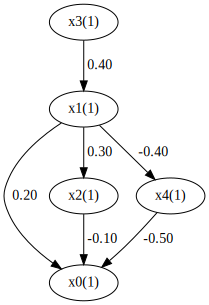

In [6]:
# B(1,1)
B_t_true[3] = np.array([[0.0, 0.2,-0.1, 0.0,-0.5],
                        [0.0, 0.0, 0.0, 0.4, 0.0],
                        [0.0, 0.3, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0,-0.4, 0.0, 0.0, 0.0]])
causal_orders.append([3, 1, 2, 4, 0])
make_dot(B_t_true[3], labels=[f'x{i}(1)' for i in range(5)])

In [7]:
# create B(t,t-τ) and X
for t in range(n_timepoints):
    # external influence
    expon = 0.1
    ext = np.empty((n_features, n_samples))
    for i in range(n_features):
        ext[i, :] = np.random.normal(size=(1, n_samples));
        ext[i, :] = np.multiply(np.sign(ext[i, :]), abs(ext[i, :]) ** expon);
        ext[i, :] = ext[i, :] - np.mean(ext[i, :]);
        ext[i, :] = ext[i, :] / np.std(ext[i, :]);

    # create B(t,t-τ)
    for tau in range(n_lags):
        value = np.random.uniform(low=0.01, high=0.5, size=(n_features, n_features))
        sign = np.random.choice([-1, 1], size=(n_features, n_features))
        B_tau_true[t, tau] = np.multiply(value, sign)

    # create X(t)
    X = np.zeros((n_features, n_samples))
    for co in causal_orders[t]:
        X[co] = np.dot(B_t_true[t][co, :], X) + ext[co]
        if t > 0:
            for tau in range(n_lags):
                X[co] = X[co] + np.dot(B_tau_true[t, tau][co, :], X_t[t-(tau+1)].T)
    
    X_t[t] = X.T

## Causal Discovery
To run causal discovery, we create a `LongitudinalLiNGAM` object by specifying the `n_lags` parameter. Then, we call the `fit` method. 

In [8]:
model = lingam.LongitudinalLiNGAM(n_lags=n_lags)
model = model.fit(X_t)

Using the `causal_orders_` property, we can see the causal ordering in time-points as a result of the causal discovery. 
All elements are nan because the causal order of B(t,t) at t=0 is not calculated.
So access to the time points above t=1.

In [9]:
print(model.causal_orders_[0]) # nan at t=0
print(model.causal_orders_[1])
print(model.causal_orders_[2])
print(model.causal_orders_[3])

[nan, nan, nan, nan, nan]
[3, 1, 2, 4, 0]
[0, 2, 3, 4, 1]
[3, 1, 2, 4, 0]


Also, using the `adjacency_matrices_` property, we can see the adjacency matrix as a result of the causal discovery.
As with the causal order, all elements are nan because the B(t,t) and B(t,t-τ) at t=0 is not calculated. 
So access to the time points above t=1.
Also, if we run causal discovery with n_lags=2, B(t,t-τ) at t=1 is also not computed, so all the elements are nan.

In [10]:
t = 0 # nan at t=0
print('B(0,0):')
print(model.adjacency_matrices_[t, 0])
print('B(0,-1):')
print(model.adjacency_matrices_[t, 1])

t = 1
print('B(1,1):')
print(model.adjacency_matrices_[t, 0])
print('B(1,0):')
print(model.adjacency_matrices_[t, 1])

t = 2
print('B(2,2):')
print(model.adjacency_matrices_[t, 0])
print('B(2,1):')
print(model.adjacency_matrices_[t, 1])

t = 2
print('B(3,3):')
print(model.adjacency_matrices_[t, 0])
print('B(3,1):')
print(model.adjacency_matrices_[t, 1])

B(0,0):
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
B(0,-1):
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
B(1,1):
[[ 0.     0.164  0.     0.    -0.45 ]
 [ 0.     0.     0.     0.516  0.   ]
 [ 0.     0.318  0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.    -0.442  0.     0.     0.   ]]
B(1,0):
[[-0.29  -0.248 -0.174 -0.293  0.121]
 [-0.228  0.26   0.311  0.159  0.37 ]
 [ 0.377  0.193 -0.619  0.408 -0.47 ]
 [-0.288 -0.359  0.387 -0.306 -0.412]
 [ 0.263  0.255  0.011 -0.59   0.378]]
B(2,2):
[[ 0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.622  0.     0.452]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.256  0.     0.   ]
 [ 0.28   0.     0.     0.     0.   ]]
B(2,1):
[[-0.333 -0.386 -0.416  0.08   0.521]
 [-0.27  -0.28  -0.031 -0.33  -0.012]
 [ 0.499 -0.176 -0.27   0.155  0.046]
 [ 0.174  0.133  0.507 -0.182 -0

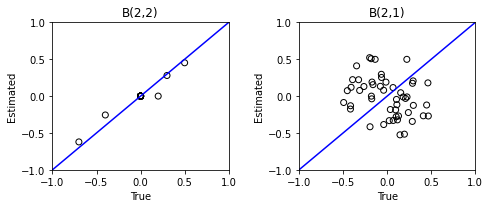

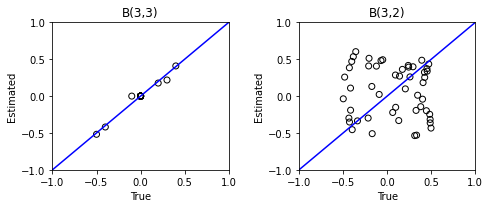

In [11]:
for t in range(2, n_timepoints):
    B = model.adjacency_matrices_[t]
    B_t = B[0]
    B_tau = B[1:]
    
    plt.figure(figsize=(7, 3))

    plt.subplot(1,2,1)
    plt.plot([-1, 1],[-1, 1], marker="", color="blue", label="support")
    plt.scatter(B_t_true[t], B_t, facecolors='none', edgecolors='black')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('True')
    plt.ylabel('Estimated')
    plt.title(f'B({t},{t})')

    plt.subplot(1,2,2)
    plt.plot([-1, 1],[-1, 1], marker="", color="blue", label="support")
    plt.scatter(B_tau_true[t], B_tau, facecolors='none', edgecolors='black')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel('True')
    plt.ylabel('Estimated')
    plt.title(f'B({t},{t-1})')

    plt.tight_layout()
    plt.show()

In [12]:
raise ValueError("Why is the estimation of lagged effects random uniformly?")

ValueError: Why is the estimation of lagged effects random uniformly?

## Independence between error variables
To check if the LiNGAM assumption is broken, we can get p-values of independence between error variables. The value in the i-th row and j-th column of the obtained matrix shows the p-value of the independence of the error variables $e_i$ and $e_j$.

In [ ]:
p_values_list = model.get_error_independence_p_values()

In [ ]:
t = 1
print(p_values_list[t])

In [ ]:
t = 2
print(p_values_list[2])

## Bootstrapping
We call `bootstrap()` method instead of `fit()`. Here, the second argument specifies the number of bootstrap sampling.

In [ ]:
model = lingam.LongitudinalLiNGAM()
result = model.bootstrap(X_t, n_sampling=100)

## Causal Directions
Since `LongitudinalBootstrapResult` object is returned, we can get the ranking of the causal directions extracted by `get_causal_direction_counts()` method. In the following sample code, `n_directions` option is limited to the causal directions of the top 8 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.01 or more.

In [ ]:
cdc_list = result.get_causal_direction_counts(n_directions=12, min_causal_effect=0.01, split_by_causal_effect_sign=True)

In [ ]:
t = 1
labels = [f'x{i}({u})' for u in [t, t-1] for i in range(5)]
print_causal_directions(cdc_list[t], 100, labels=labels)

In [ ]:
t = 2
labels = [f'x{i}({u})' for u in [t, t-1] for i in range(5)]
print_causal_directions(cdc_list[t], 100, labels=labels)

## Directed Acyclic Graphs
Also, using the `get_directed_acyclic_graph_counts()` method, we can get the ranking of the DAGs extracted. In the following sample code, `n_dags` option is limited to the dags of the top 3 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.01 or more.

In [ ]:
dagc_list = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)

In [ ]:
t = 1
labels = [f'x{i}({u})' for u in [t, t-1] for i in range(5)]
print_dagc(dagc_list[t], 100, labels=labels)

In [ ]:
t = 2
labels = [f'x{i}({u})' for u in [t, t-1] for i in range(5)]
print_dagc(dagc_list[t], 100, labels=labels)

## Probability
Using the `get_probabilities()` method, we can get the probability of bootstrapping.

In [ ]:
probs = result.get_probabilities(min_causal_effect=0.01)
print(probs[1])

In [ ]:
t = 1
print('B(1,1):')
print(probs[t, 0])
print('B(1,0):')
print(probs[t, 1])

t = 2
print('B(2,2):')
print(probs[t, 0])
print('B(2,1):')
print(probs[t, 1])

## Total Causal Effects
Using the `get_total_causal_effects()` method, we can get the list of total causal effect. The total causal effects we can get are dictionary type variable.
We can display the list nicely by assigning it to pandas.DataFrame. Also, we have replaced the variable index with a label below.

In [ ]:
causal_effects = result.get_total_causal_effects(min_causal_effect=0.01)

df = pd.DataFrame(causal_effects)

labels = [f'x{i}({t})' for t in range(3) for i in range(5)]
df['from'] = df['from'].apply(lambda x : labels[x])
df['to'] = df['to'].apply(lambda x : labels[x])
df

We can easily perform sorting operations with pandas.DataFrame.

In [ ]:
df.sort_values('effect', ascending=False).head()

And with pandas.DataFrame, we can easily filter by keywords. The following code extracts the causal direction towards x0(2).

In [ ]:
df[df['to']=='x0(2)'].head()

Because it holds the raw data of the total causal effect (the original data for calculating the median), it is possible to draw a histogram of the values of the causal effect, as shown below.

In [ ]:
x = np.arange(5)
x

In [ ]:
x[2:1:-1]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from_index = 5 # index of x0(1). (index:0)+(n_features:5)*(timepoint:1) = 5
to_index = 12 # index of x2(2). (index:2)+(n_features:5)*(timepoint:2) = 12
plt.hist(result.total_effects_[:, to_index, from_index])

In [ ]:
x = np.arange(50).reshape(5, 10)
x

In [ ]:
np.split(x, 2, axis=1)